# Artificial Intelligence Nanodegree
## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [2]:
# !unrar x /content/data.rar

### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [3]:
import collections
import os
import numpy as np
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18298820507853914298
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7024730903479746269
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [4]:
def load_data(path):
    input_file = os.path.join(path)
    with open(input_file, "r", encoding="utf-8") as f:
        data = f.read()

    return data.split('\n')

In [5]:
# Load English data
english_sentences = load_data('/content/data/small_vocab_en')
# Load French data
french_sentences = load_data('/content/data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [6]:
for i in range(2):
    print(f'small_vocab_en Line {i + 1}:  {english_sentences[i]}')
    print(f'small_vocab_fr Line {i + 1}:  {french_sentences[i]}')

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [7]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print(f'{len([word for sentence in english_sentences for word in sentence.split()])} English words.')
print(f'{len(english_words_counter)} unique English words.')
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print(f'{len([word for sentence in french_sentences for word in sentence.split()])} French words.')
print(f'{len(french_words_counter)} unique French words.')
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [8]:
from keras.preprocessing.text import Tokenizer

def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'<OOV>': 1, 'the': 2, 'quick': 3, 'a': 4, 'brown': 5, 'fox': 6, 'jumps': 7, 'over': 8, 'lazy': 9, 'dog': 10, 'by': 11, 'jove': 12, 'my': 13, 'study': 14, 'of': 15, 'lexicography': 16, 'won': 17, 'prize': 18, 'this': 19, 'is': 20, 'short': 21, 'sentence': 22}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [2, 3, 5, 6, 7, 8, 2, 9, 10]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [11, 12, 13, 3, 14, 15, 16, 17, 4, 18]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [19, 20, 4, 21, 22]


### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(s) for s in x])
    return pad_sequences(x, maxlen=length, padding='post')

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [ 2  3  5  6  7  8  2  9 10]
  Output: [ 2  3  5  6  7  8  2  9 10  0]
Sequence 2 in x
  Input:  [11 12 13  3 14 15 16 17  4 18]
  Output: [11 12 13  3 14 15 16 17  4 18]
Sequence 3 in x
  Input:  [19 20  4 21 22]
  Output: [19 20  4 21 22  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [10]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 200
French vocabulary size: 345


## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [11]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

### Model 1: RNN (IMPLEMENTATION)
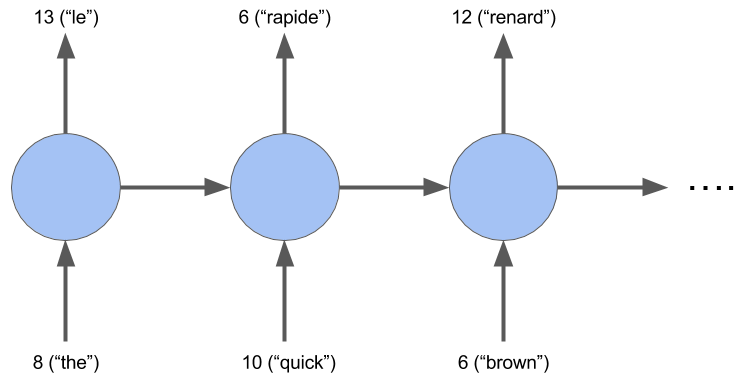

A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

**NOTES:**
- The `return_state` contructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.
- The `inital_state` call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.
- The `return_sequences` constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the *decoder*.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed

def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape[1:]),
        TimeDistributed(Dense(french_vocab_size, activation='softmax'))
    ])

    # Compile model
    model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
# Turn the sentences into 3 Numpy arrays
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
y = preproc_french_sentences

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)
simple_rnn_model.summary()

# Run training on GPU
simple_rnn_model.fit(tmp_x, y, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print('\nEnglish:', english_sentences[0])
print('Frensh:', french_sentences[0])
print('\nFrensh (PREDICTED):',
      logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 128)           50304     
                                                                 
 time_distributed (TimeDistr  (None, 21, 345)          44505     
 ibuted)                                                         
                                                                 
Total params: 94,809
Trainable params: 94,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
108/108 [==============================] - 8s 22ms/step - loss: 2.9419 - accuracy: 0.4457 - val_loss: nan - val_accuracy: 0.4836
Epoch 2/10
108/108 [==============================] - 2s 18ms/step - loss: 2.1139 - accuracy: 0.5186 - val_loss: nan - val_accuracy: 0.5613
Epoch 3/10
108/108 [==============================] - 2s 17ms/step - loss: 1.7345 - accuracy: 0.5716 -

### Model 2: Embedding (IMPLEMENTATION)

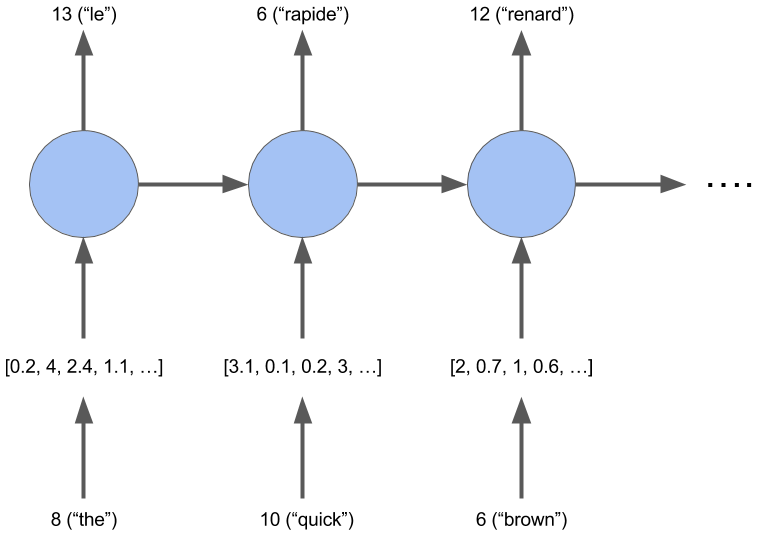

You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [13]:
from tensorflow.keras.layers import Embedding

def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    embedding_size = 128
    model = Sequential([
        Embedding(french_vocab_size, embedding_size, input_length=input_shape[1]), #(345, 128, 21)
        GRU(128, return_sequences=True),
        TimeDistributed(Dense(french_vocab_size, activation='softmax')) 
    ])

    # Compile model
    model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[1], 1))
y = preproc_french_sentences

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size, french_vocab_size)

embed_rnn_model.summary()
embed_rnn_model.fit(tmp_x, y, batch_size=64, epochs=10, validation_split=0.2)

# TODO: Print prediction(s)
print('\nEnglish:', english_sentences[0])
print('Frensh:', french_sentences[0])
print('\nFrensh (PREDICTED):',
      logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 128)           44160     
                                                                 
 gru_1 (GRU)                 (None, 21, 128)           99072     
                                                                 
 time_distributed_1 (TimeDis  (None, 21, 345)          44505     
 tributed)                                                       
                                                                 
Total params: 187,737
Trainable params: 187,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1724/1724 [==============================] - 13s 7ms/step - loss: 0.9910 - accuracy: 0.7635 - val_loss: nan - val_accuracy: 0.8725
Epoch 2/10
1724/1724 [==============================] - 14s 8ms/step - loss: 0.3531 - accuracy: 0.8895 -

WOW! just by adding an Embedding layer, we get an accuracy boost of 24%, to reach 93% 👏

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
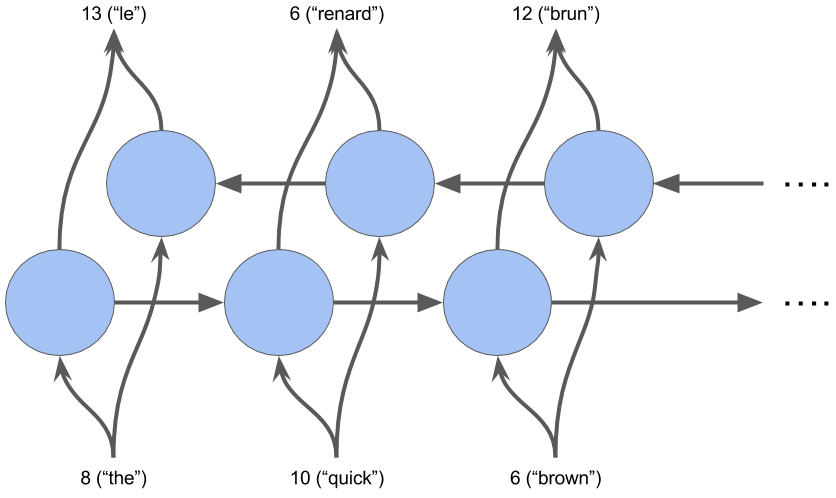

One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [14]:
from tensorflow.keras.layers import Bidirectional

def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    embedding_size = 128
    model = Sequential([
        Embedding(french_vocab_size, embedding_size, input_length=input_shape[1]), #(345, 128, 21)
        Bidirectional(GRU(128, return_sequences=True)),
        TimeDistributed(Dense(french_vocab_size, activation='softmax'))  
    ])

    # Compile model
    model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model


# TODO: Train and Print prediction(s)
# Reshaping the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[1], 1))
y = preproc_french_sentences

# Training the neural network
bd_rnn_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size, french_vocab_size)

bd_rnn_model.summary()
bd_rnn_model.fit(tmp_x, y, batch_size=64, epochs=10, validation_split=0.2)

# TODO: Print prediction(s)
print('\nEnglish:', english_sentences[0])
print('Frensh:', french_sentences[0])
print('\nFrensh (PREDICTED):',
      logits_to_text(bd_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 128)           44160     
                                                                 
 bidirectional (Bidirectiona  (None, 21, 256)          198144    
 l)                                                              
                                                                 
 time_distributed_2 (TimeDis  (None, 21, 345)          88665     
 tributed)                                                       
                                                                 
Total params: 330,969
Trainable params: 330,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1724/1724 [==============================] - 18s 9ms/step - loss: 0.8307 - accuracy: 0.7944 - val_loss: nan - val_accuracy: 0.9053
Epoch 2/10
1724/1724 [================

WOW! just by adding an Embedding layer, we get an accuracy boost of 4%, to reach 97% 👏


### Model 4: Encoder-Decoder (OPTIONAL)

Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [17]:
from tensorflow.keras.layers import RepeatVector

def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    encoder = Sequential([
        GRU(128, input_shape=input_shape[1:]),
    ])

    decoder = Sequential([
        GRU(128, return_sequences=True),
        Dense(french_vocab_size, activation="softmax")
    ])

    model = Sequential([
        encoder,
        RepeatVector(output_sequence_length), # (21)
        decoder
    ])

    # Compile model
    model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model


# TODO: Train and Print prediction(s)

# Reshaping the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[1], 1))
y = preproc_french_sentences

# Training the neural network
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size, french_vocab_size)

encdec_rnn_model.summary()
encdec_rnn_model.fit(tmp_x, y, batch_size=64, epochs=10, validation_split=0.2)

# Printing prediction(s)
print('\nEnglish:', english_sentences[0])
print('Frensh:', french_sentences[0])
print('\nFrensh (PREDICTED):',
      logits_to_text(encdec_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 128)               50304     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 21, 128)          0         
 or)                                                             
                                                                 
 sequential_7 (Sequential)   (None, 21, 345)           143577    
                                                                 
Total params: 193,881
Trainable params: 193,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1724/1724 [==============================] - 18s 9ms/step - loss: 1.8764 - accuracy: 0.5528 - val_loss: nan - val_accuracy: 0.6122
Epoch 2/10
1724/1724 [==============================] - 14s 8ms/step - loss: 1.3262 - accuracy: 0.6280 -

Better than the Simple RNN

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [21]:
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.layers import RepeatVector
# from tensorflow.keras.layers import Bidirectional

def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    embedding_size = 128
    encoder = Sequential([
        Embedding(french_vocab_size, embedding_size, input_length=input_shape[1]),
        Bidirectional(GRU(128))
    ])

    decoder = Sequential([
        Bidirectional(GRU(128, return_sequences=True)),
        TimeDistributed(Dense(french_vocab_size, activation='softmax'))
    ])

    model = Sequential([
        encoder,
        RepeatVector(output_sequence_length),
        decoder
    ])

    # Compile model
    model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
    return model


print('Final Model Loaded')

# TODO: Train the final model
# Reshaping the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[1], 1))
y = preproc_french_sentences

# Training the neural network
final_rnn_model = model_final(
    tmp_x.shape, max_french_sequence_length,
    english_vocab_size, french_vocab_size)

final_rnn_model.summary()
final_rnn_model.fit(tmp_x, y, batch_size=64, epochs=10, validation_split=0.2)

# Printing prediction(s)
print('\nEnglish:', english_sentences[0])
print('Frensh:', french_sentences[0])
print('\nFrensh (PREDICTED):',
      logits_to_text(final_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Final Model Loaded
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 256)               242304    
                                                                 
 repeat_vector_4 (RepeatVect  (None, 21, 256)          0         
 or)                                                             
                                                                 
 sequential_17 (Sequential)  (None, 21, 345)           385113    
                                                                 
Total params: 627,417
Trainable params: 627,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1724/1724 [==============================] - 29s 14ms/step - loss: 1.2834 - accuracy: 0.6729 - val_loss: nan - val_accuracy: 0.7594
Epoch 2/10
1724/1724 [==============================] - 22s 13ms/step - loss: 0.640

1/1 [==============================] - 1s 1s/step

Frensh (PREDICTED): new jersey est parfois calme pendant l' automne et est et il est avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


## Prediction (IMPLEMENTATION)

In [23]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    # TODO: Train neural network using model_final
    model = model_final(x.shape, y.shape[1],
                        len(x_tk.word_index),
                        len(y_tk.word_index))
    
    model.summary()
    model.fit(x, y, batch_size=64, epochs=10, validation_split=0.2)

    
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 256)               242304    
                                                                 
 repeat_vector_6 (RepeatVect  (None, 21, 256)          0         
 or)                                                             
                                                                 
 sequential_23 (Sequential)  (None, 21, 345)           385113    
                                                                 
Total params: 627,417
Trainable params: 627,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1724/1724 [==============================] - 28s 13ms/step - loss: 1.2548 - accuracy: 0.6751 - val_loss: nan - val_accuracy: 0.7645
Epoch 2/10
1724/1724 [==============================] - 21s 12ms/step - loss: 0.6197 - accuracy: 0.816

## Submission
When you're ready to submit, complete the following steps:
1. Review the [rubric](https://review.udacity.com/#!/rubrics/1004/view) to ensure your submission meets all requirements to pass
2. Generate an HTML version of this notebook

  - Run the next cell to attempt automatic generation (this is the recommended method in Workspaces)
  - Navigate to **FILE -> Download as -> HTML (.html)**
  - Manually generate a copy using `nbconvert` from your shell terminal
```
$ pip install nbconvert
$ python -m nbconvert machine_translation.ipynb
```
  
3. Submit the project

  - If you are in a Workspace, simply click the "Submit Project" button (bottom towards the right)
  
  - Otherwise, add the following files into a zip archive and submit them 
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.

In [ ]:
!python -m nbconvert *.ipynb

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?